In [4]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 3
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 3
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

3
179
(84, 1972)
(11, 1972)


[I 2025-05-20 16:03:52,955] A new study created in memory with name: no-name-eb2b1a06-aff4-4152-8a1a-9014a5296734
[I 2025-05-20 16:09:40,532] Trial 0 finished with value: 0.048742123693227765 and parameters: {'lr': 0.07170827610081416, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1255589426476339}. Best is trial 0 with value: 0.048742123693227765.


Cross Validation Accuracies:
[0.044181693345308304, 0.034697238355875015, 0.06758756935596466, 0.05035346746444702, 0.04689064994454384]
Mean Cross Validation Accuracy:
0.048742123693227765
Standard Deviation of Cross Validation Accuracy:
0.010763192232008986


[I 2025-05-20 16:13:28,013] Trial 1 finished with value: 0.05045340731739998 and parameters: {'lr': 0.00695503649288909, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15487057080782163}. Best is trial 0 with value: 0.048742123693227765.


Cross Validation Accuracies:
[0.037321873009204865, 0.05781228840351105, 0.06903942674398422, 0.04336712136864662, 0.04472632706165314]
Mean Cross Validation Accuracy:
0.05045340731739998
Standard Deviation of Cross Validation Accuracy:
0.011445919264571633


[I 2025-05-20 16:16:59,802] Trial 2 finished with value: 0.07834333628416061 and parameters: {'lr': 0.022417983931193253, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15665844583861577}. Best is trial 0 with value: 0.048742123693227765.


Cross Validation Accuracies:
[0.11256590485572815, 0.060449063777923584, 0.09593334794044495, 0.05159972608089447, 0.07116863876581192]
Mean Cross Validation Accuracy:
0.07834333628416061
Standard Deviation of Cross Validation Accuracy:
0.022660514863592007


[I 2025-05-20 16:22:20,249] Trial 3 finished with value: 0.04310917109251022 and parameters: {'lr': 0.0029533499173309903, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13416040811538799}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03549659624695778, 0.032413505017757416, 0.05561570078134537, 0.04774607717990875, 0.0442739762365818]
Mean Cross Validation Accuracy:
0.04310917109251022
Standard Deviation of Cross Validation Accuracy:
0.008385934921122152


[I 2025-05-20 16:27:48,028] Trial 4 finished with value: 5.854592323303223 and parameters: {'lr': 0.06195581122961781, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.448665763353428}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[4.894730567932129, 6.318635940551758, 5.536495685577393, 5.965303421020508, 6.557796001434326]
Mean Cross Validation Accuracy:
5.854592323303223
Standard Deviation of Cross Validation Accuracy:
0.5906960130491046


[I 2025-05-20 16:32:53,819] Trial 5 finished with value: 0.04500143751502037 and parameters: {'lr': 0.001740450184617474, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19595032043327854}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04343944415450096, 0.03421923518180847, 0.05768983066082001, 0.04576199874281883, 0.04389667883515358]
Mean Cross Validation Accuracy:
0.04500143751502037
Standard Deviation of Cross Validation Accuracy:
0.007503198999852974


[I 2025-05-20 16:36:43,234] Trial 6 finished with value: 0.0615689679980278 and parameters: {'lr': 0.0075113656212582175, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4836380767582622}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03688856214284897, 0.0720791146159172, 0.09714987874031067, 0.04488839954137802, 0.05683888494968414]
Mean Cross Validation Accuracy:
0.0615689679980278
Standard Deviation of Cross Validation Accuracy:
0.02138317971695223


[I 2025-05-20 16:41:58,596] Trial 7 finished with value: 0.04532457441091538 and parameters: {'lr': 0.18395342711869808, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4288039615011161}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.0413418747484684, 0.03578375652432442, 0.05536406859755516, 0.05183612182736397, 0.04229705035686493]
Mean Cross Validation Accuracy:
0.04532457441091538
Standard Deviation of Cross Validation Accuracy:
0.007200648550296503


[I 2025-05-20 16:49:41,204] Trial 8 finished with value: 0.20947172045707702 and parameters: {'lr': 0.4174118522940691, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.457125967924923}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.1860199123620987, 0.2179180532693863, 0.21570825576782227, 0.21754074096679688, 0.210171639919281]
Mean Cross Validation Accuracy:
0.20947172045707702
Standard Deviation of Cross Validation Accuracy:
0.012048412283965113


[I 2025-05-20 16:53:04,413] Trial 9 finished with value: 3.395699691772461 and parameters: {'lr': 0.037591538247914134, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3230578032446604}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[2.268787384033203, 3.692072868347168, 4.151793003082275, 3.6511952877044678, 3.2146499156951904]
Mean Cross Validation Accuracy:
3.395699691772461
Standard Deviation of Cross Validation Accuracy:
0.6367892155953842


[I 2025-05-20 16:55:40,389] Trial 10 finished with value: 0.049949637800455096 and parameters: {'lr': 0.0010617728060476727, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.255865278172558}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.05161543935537338, 0.03444230183959007, 0.05716497078537941, 0.049893900752067566, 0.056631576269865036]
Mean Cross Validation Accuracy:
0.049949637800455096
Standard Deviation of Cross Validation Accuracy:
0.008245784399732822


[I 2025-05-20 16:58:03,497] Trial 11 finished with value: 0.043766269087791444 and parameters: {'lr': 0.0010130545317908284, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22485871513436861}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.039754293859004974, 0.033675167709589005, 0.05659094080328941, 0.04371481016278267, 0.04509613290429115]
Mean Cross Validation Accuracy:
0.043766269087791444
Standard Deviation of Cross Validation Accuracy:
0.007538828326248678


[I 2025-05-20 17:00:19,681] Trial 12 finished with value: 0.04583805203437805 and parameters: {'lr': 0.0037995815610488344, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26843886151462976}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03808119148015976, 0.03467273712158203, 0.06386342644691467, 0.04189211502671242, 0.05068079009652138]
Mean Cross Validation Accuracy:
0.04583805203437805
Standard Deviation of Cross Validation Accuracy:
0.010476352383140038


[I 2025-05-20 17:02:56,099] Trial 13 finished with value: 0.04378189668059349 and parameters: {'lr': 0.002944417473543835, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21423776837055167}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03784114122390747, 0.03596866503357887, 0.05638785660266876, 0.04414358735084534, 0.04456823319196701]
Mean Cross Validation Accuracy:
0.04378189668059349
Standard Deviation of Cross Validation Accuracy:
0.0071553970535965334


[I 2025-05-20 17:05:47,305] Trial 14 finished with value: 0.09188945442438126 and parameters: {'lr': 0.012979916655567532, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.34779278876273645}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.09745490550994873, 0.08819057792425156, 0.08655015379190445, 0.09000200033187866, 0.09724963456392288]
Mean Cross Validation Accuracy:
0.09188945442438126
Standard Deviation of Cross Validation Accuracy:
0.00459256090809179


[I 2025-05-20 17:08:00,764] Trial 15 finished with value: 0.09264692068099975 and parameters: {'lr': 0.001176274442670843, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2079909486825599}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.10224661976099014, 0.20747141540050507, 0.0595293790102005, 0.04826370254158974, 0.04572348669171333]
Mean Cross Validation Accuracy:
0.09264692068099975
Standard Deviation of Cross Validation Accuracy:
0.06090200175050172


[I 2025-05-20 17:10:08,448] Trial 16 finished with value: 0.04571305587887764 and parameters: {'lr': 0.003168419116152683, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10257124617282995}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03843572735786438, 0.0393751859664917, 0.05660494416952133, 0.04469858109951019, 0.049450840801000595]
Mean Cross Validation Accuracy:
0.04571305587887764
Standard Deviation of Cross Validation Accuracy:
0.0067344120926323406


[I 2025-05-20 17:12:07,958] Trial 17 finished with value: 0.1569526880979538 and parameters: {'lr': 0.9436970739479622, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.371340200823145}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.16311050951480865, 0.14487628638744354, 0.16285572946071625, 0.1587524265050888, 0.15516848862171173]
Mean Cross Validation Accuracy:
0.1569526880979538
Standard Deviation of Cross Validation Accuracy:
0.006708599947993845


[I 2025-05-20 17:17:53,965] Trial 18 finished with value: 0.05477768480777741 and parameters: {'lr': 0.006270783577210604, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2520233108626762}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04076787084341049, 0.08166150003671646, 0.05486581474542618, 0.05133061110973358, 0.04526262730360031]
Mean Cross Validation Accuracy:
0.05477768480777741
Standard Deviation of Cross Validation Accuracy:
0.014292940997942713


[I 2025-05-20 17:19:48,719] Trial 19 finished with value: 0.05034298598766327 and parameters: {'lr': 0.0021291803688817976, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.16742952794589663}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.05444902554154396, 0.038748059421777725, 0.060736820101737976, 0.04732784256339073, 0.05045318230986595]
Mean Cross Validation Accuracy:
0.05034298598766327
Standard Deviation of Cross Validation Accuracy:
0.007327167304976394


[I 2025-05-20 17:21:50,207] Trial 20 finished with value: 0.09896845519542694 and parameters: {'lr': 0.014518996564868658, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.29976348935352304}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.10262954980134964, 0.09379765391349792, 0.0984187200665474, 0.10449729114770889, 0.09549906104803085]
Mean Cross Validation Accuracy:
0.09896845519542694
Standard Deviation of Cross Validation Accuracy:
0.0040754811019037


[I 2025-05-20 17:23:53,473] Trial 21 finished with value: 0.04604254439473152 and parameters: {'lr': 0.003165011975401921, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22222399386657787}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04419739916920662, 0.03715680167078972, 0.05946316942572594, 0.04434555768966675, 0.045049794018268585]
Mean Cross Validation Accuracy:
0.04604254439473152
Standard Deviation of Cross Validation Accuracy:
0.007298485843913787


[I 2025-05-20 17:25:57,082] Trial 22 finished with value: 0.044900736212730406 and parameters: {'lr': 0.0015975405822419055, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2233597175160064}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04181160405278206, 0.034989312291145325, 0.05714979022741318, 0.04444525018334389, 0.04610772430896759]
Mean Cross Validation Accuracy:
0.044900736212730406
Standard Deviation of Cross Validation Accuracy:
0.007203924953760093


[I 2025-05-20 17:28:00,945] Trial 23 finished with value: 0.045014528930187224 and parameters: {'lr': 0.004759577411163897, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1826028331602234}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03693417087197304, 0.037207577377557755, 0.0561203733086586, 0.049047354608774185, 0.04576316848397255]
Mean Cross Validation Accuracy:
0.045014528930187224
Standard Deviation of Cross Validation Accuracy:
0.007299378088415988


[I 2025-05-20 17:30:08,721] Trial 24 finished with value: 0.04398373588919639 and parameters: {'lr': 0.0010382364698093638, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13541816066475218}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.039104387164115906, 0.034487515687942505, 0.0565841943025589, 0.0450453944504261, 0.04469718784093857]
Mean Cross Validation Accuracy:
0.04398373588919639
Standard Deviation of Cross Validation Accuracy:
0.00740802169147205


[I 2025-05-20 17:32:08,267] Trial 25 finished with value: 0.04407305419445038 and parameters: {'lr': 0.0022732847621050123, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2791273515651843}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03449160233139992, 0.03243021294474602, 0.056936562061309814, 0.0509926937520504, 0.04551419988274574]
Mean Cross Validation Accuracy:
0.04407305419445038
Standard Deviation of Cross Validation Accuracy:
0.009410506036473497


[I 2025-05-20 17:34:34,138] Trial 26 finished with value: 0.08291660249233246 and parameters: {'lr': 0.011262921895267002, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.23416201735768208}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.10579871386289597, 0.0661616325378418, 0.09604866057634354, 0.07047449052333832, 0.07609951496124268]
Mean Cross Validation Accuracy:
0.08291660249233246
Standard Deviation of Cross Validation Accuracy:
0.015349591663155892


[I 2025-05-20 17:37:27,387] Trial 27 finished with value: 0.045979772508144376 and parameters: {'lr': 0.0024132327561771313, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18814828580345086}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.044475946575403214, 0.03283041715621948, 0.05575577914714813, 0.04768768697977066, 0.049149032682180405]
Mean Cross Validation Accuracy:
0.045979772508144376
Standard Deviation of Cross Validation Accuracy:
0.007532576269858109


[I 2025-05-20 17:40:40,214] Trial 28 finished with value: 1.7201928615570068 and parameters: {'lr': 0.022850634390801504, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10008362865772318}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[2.050320863723755, 2.0471792221069336, 1.859290361404419, 1.6259639263153076, 1.0182099342346191]
Mean Cross Validation Accuracy:
1.7201928615570068
Standard Deviation of Cross Validation Accuracy:
0.38390410645185574


[I 2025-05-20 17:45:23,282] Trial 29 finished with value: 0.054224543273448944 and parameters: {'lr': 0.0044415880680865865, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13361186667533284}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04241207242012024, 0.06518872827291489, 0.05661435425281525, 0.042922474443912506, 0.06398508697748184]
Mean Cross Validation Accuracy:
0.054224543273448944
Standard Deviation of Cross Validation Accuracy:
0.00988396671490014


[I 2025-05-20 17:48:29,269] Trial 30 finished with value: 0.04753730818629265 and parameters: {'lr': 0.11757250807017791, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2927318603633166}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04247533157467842, 0.03746005520224571, 0.06962666660547256, 0.04269454628229141, 0.04542994126677513]
Mean Cross Validation Accuracy:
0.04753730818629265
Standard Deviation of Cross Validation Accuracy:
0.011340262152916303


[I 2025-05-20 17:50:36,323] Trial 31 finished with value: 0.044658160954713824 and parameters: {'lr': 0.0010506093024704, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14796251357443813}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04067719355225563, 0.036614805459976196, 0.05598730966448784, 0.04417998343706131, 0.04583151265978813]
Mean Cross Validation Accuracy:
0.044658160954713824
Standard Deviation of Cross Validation Accuracy:
0.006488431051102016


[I 2025-05-20 17:52:50,802] Trial 32 finished with value: 0.044176448881626126 and parameters: {'lr': 0.0013256711141367277, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12575216578631154}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04020121321082115, 0.03551871329545975, 0.05614630877971649, 0.04392785206437111, 0.045088157057762146]
Mean Cross Validation Accuracy:
0.044176448881626126
Standard Deviation of Cross Validation Accuracy:
0.006854625332931136


[I 2025-05-20 17:55:05,112] Trial 33 finished with value: 0.045084874331951144 and parameters: {'lr': 0.0018270088378842001, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17435147354021802}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04190943390130997, 0.03370609134435654, 0.05620906129479408, 0.04964619502425194, 0.04395359009504318]
Mean Cross Validation Accuracy:
0.045084874331951144
Standard Deviation of Cross Validation Accuracy:
0.007555039513785428


[I 2025-05-20 17:57:58,012] Trial 34 finished with value: 0.052857677638530734 and parameters: {'lr': 0.0077695135459627754, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14079912800387623}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03526045382022858, 0.06479758769273758, 0.06723570823669434, 0.04368031397461891, 0.05331432446837425]
Mean Cross Validation Accuracy:
0.052857677638530734
Standard Deviation of Cross Validation Accuracy:
0.012193309905375115


[I 2025-05-20 17:59:48,158] Trial 35 finished with value: 0.04664088189601898 and parameters: {'lr': 0.0024366599050568705, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11647179440996731}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.041412945836782455, 0.039312612265348434, 0.056825097650289536, 0.048568371683359146, 0.04708538204431534]
Mean Cross Validation Accuracy:
0.04664088189601898
Standard Deviation of Cross Validation Accuracy:
0.006142733902928605


[I 2025-05-20 18:02:57,776] Trial 36 finished with value: 0.046171847730875015 and parameters: {'lr': 0.0015563871681235906, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1631386661338766}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04238389804959297, 0.03509819507598877, 0.05647603049874306, 0.04976813495159149, 0.047132980078458786]
Mean Cross Validation Accuracy:
0.046171847730875015
Standard Deviation of Cross Validation Accuracy:
0.007169485136131927


[I 2025-05-20 18:05:57,806] Trial 37 finished with value: 0.04437849074602127 and parameters: {'lr': 0.004974262106068257, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20165719756965916}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04028329625725746, 0.032027602195739746, 0.05632026493549347, 0.049043335020542145, 0.04421795532107353]
Mean Cross Validation Accuracy:
0.04437849074602127
Standard Deviation of Cross Validation Accuracy:
0.008169548095247552


[I 2025-05-20 18:08:10,478] Trial 38 finished with value: 0.04615423753857613 and parameters: {'lr': 0.0030199099785625035, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.23997017643365554}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03960142284631729, 0.032751694321632385, 0.05895929038524628, 0.04605865478515625, 0.05340012535452843]
Mean Cross Validation Accuracy:
0.04615423753857613
Standard Deviation of Cross Validation Accuracy:
0.009370687805953846


[I 2025-05-20 18:10:24,504] Trial 39 finished with value: 0.10366073325276375 and parameters: {'lr': 0.009438408962341757, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1496542960046558}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.08914871513843536, 0.051791880279779434, 0.09100223332643509, 0.06414341181516647, 0.22221742570400238]
Mean Cross Validation Accuracy:
0.10366073325276375
Standard Deviation of Cross Validation Accuracy:
0.06112040938581562


[I 2025-05-20 18:13:32,110] Trial 40 finished with value: 0.051311077922582625 and parameters: {'lr': 0.05488021464085545, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.32580069090898534}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04683385789394379, 0.040850020945072174, 0.06135298311710358, 0.05037419870495796, 0.05714432895183563]
Mean Cross Validation Accuracy:
0.051311077922582625
Standard Deviation of Cross Validation Accuracy:
0.00728318106936811


[I 2025-05-20 18:15:28,271] Trial 41 finished with value: 0.047332273423671724 and parameters: {'lr': 0.0019105552435188216, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.27734125328413595}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03455434367060661, 0.04089168831706047, 0.05703375115990639, 0.05228307098150253, 0.05189851298928261]
Mean Cross Validation Accuracy:
0.047332273423671724
Standard Deviation of Cross Validation Accuracy:
0.00829742412783148


[I 2025-05-20 18:17:43,550] Trial 42 finished with value: 0.06180885210633278 and parameters: {'lr': 0.0010444673615205846, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2142782727693997}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03624437004327774, 0.034140415489673615, 0.0595056377351284, 0.11069595068693161, 0.06845788657665253]
Mean Cross Validation Accuracy:
0.06180885210633278
Standard Deviation of Cross Validation Accuracy:
0.02777966159411867


[I 2025-05-20 18:19:47,260] Trial 43 finished with value: 0.047289516776800156 and parameters: {'lr': 0.0023217322264207775, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3958581741960138}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.036490269005298615, 0.03732011839747429, 0.05674083158373833, 0.055982720106840134, 0.049913644790649414]
Mean Cross Validation Accuracy:
0.047289516776800156
Standard Deviation of Cross Validation Accuracy:
0.008806791016327361


[I 2025-05-20 18:22:17,001] Trial 44 finished with value: 0.04438552930951119 and parameters: {'lr': 0.0014724209562570554, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2686655722187397}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03506447374820709, 0.03259843587875366, 0.05834418535232544, 0.049783650785684586, 0.046136900782585144]
Mean Cross Validation Accuracy:
0.04438552930951119
Standard Deviation of Cross Validation Accuracy:
0.009517024160441558


[I 2025-05-20 18:24:56,653] Trial 45 finished with value: 0.04826720133423805 and parameters: {'lr': 0.0025031950300719624, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.32604287264416815}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.049581825733184814, 0.0341508686542511, 0.058664049953222275, 0.04503711685538292, 0.053902145475149155]
Mean Cross Validation Accuracy:
0.04826720133423805
Standard Deviation of Cross Validation Accuracy:
0.008381880314824081


[I 2025-05-20 18:28:03,153] Trial 46 finished with value: 0.05293537378311157 and parameters: {'lr': 0.0060081205546892846, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.1924062033671241}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04685176908969879, 0.046737685799598694, 0.06625037640333176, 0.04601644352078438, 0.05882059410214424]
Mean Cross Validation Accuracy:
0.05293537378311157
Standard Deviation of Cross Validation Accuracy:
0.008188019191009097


[I 2025-05-20 18:32:17,485] Trial 47 finished with value: 0.08954746648669243 and parameters: {'lr': 0.003690625171162648, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2449032726684458}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.07848433405160904, 0.10896646231412888, 0.08753101527690887, 0.046004828065633774, 0.12675069272518158]
Mean Cross Validation Accuracy:
0.08954746648669243
Standard Deviation of Cross Validation Accuracy:
0.027508536045827255


[I 2025-05-20 18:35:08,478] Trial 48 finished with value: 0.045100902765989305 and parameters: {'lr': 0.001358585517825617, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2844771024408585}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.041381288319826126, 0.03789366036653519, 0.05677415430545807, 0.04375973343849182, 0.045695677399635315]
Mean Cross Validation Accuracy:
0.045100902765989305
Standard Deviation of Cross Validation Accuracy:
0.006390573810952403


[I 2025-05-20 18:38:01,228] Trial 49 finished with value: 0.07265504524111747 and parameters: {'lr': 0.021183759939244998, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2547292285746176}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.10484419018030167, 0.03798488900065422, 0.08957149088382721, 0.04809464514255524, 0.08278001099824905]
Mean Cross Validation Accuracy:
0.07265504524111747
Standard Deviation of Cross Validation Accuracy:
0.025416746854864163


[I 2025-05-20 18:41:30,448] Trial 50 finished with value: 0.044986991584300993 and parameters: {'lr': 0.003350805664040333, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.31424323175295144}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.038131002336740494, 0.033920638263225555, 0.05511884391307831, 0.05021902546286583, 0.04754544794559479]
Mean Cross Validation Accuracy:
0.044986991584300993
Standard Deviation of Cross Validation Accuracy:
0.007823593464141498


[I 2025-05-20 18:44:28,122] Trial 51 finished with value: 0.04474223926663399 and parameters: {'lr': 0.0010052886412432371, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12101166223143987}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04055560380220413, 0.036158014088869095, 0.05666191875934601, 0.04505906626582146, 0.045276593416929245]
Mean Cross Validation Accuracy:
0.04474223926663399
Standard Deviation of Cross Validation Accuracy:
0.006836395414674694


[I 2025-05-20 18:46:46,820] Trial 52 finished with value: 0.04564155861735344 and parameters: {'lr': 0.0015183539240444107, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12402842870301262}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04358683153986931, 0.03693227097392082, 0.05608677491545677, 0.044475261121988297, 0.047126654535532]
Mean Cross Validation Accuracy:
0.04564155861735344
Standard Deviation of Cross Validation Accuracy:
0.006208734136151163


[I 2025-05-20 18:48:34,213] Trial 53 finished with value: 0.04378156736493111 and parameters: {'lr': 0.0013570679372875984, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1575984791772515}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04012957215309143, 0.0347752571105957, 0.056097403168678284, 0.044188518077135086, 0.04371708631515503]
Mean Cross Validation Accuracy:
0.04378156736493111
Standard Deviation of Cross Validation Accuracy:
0.00701855072871104


[I 2025-05-20 18:50:25,053] Trial 54 finished with value: 0.04460610523819923 and parameters: {'lr': 0.0018658778533223975, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16397655853950224}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.040409889072179794, 0.03347928449511528, 0.05640223249793053, 0.04534832760691643, 0.04739079251885414]
Mean Cross Validation Accuracy:
0.04460610523819923
Standard Deviation of Cross Validation Accuracy:
0.00760089949393001


[I 2025-05-20 18:52:08,799] Trial 55 finished with value: 0.04401116073131561 and parameters: {'lr': 0.0012503572473636768, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17873160818096684}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04073880612850189, 0.034381214529275894, 0.05642300471663475, 0.044049110263586044, 0.04446366801857948]
Mean Cross Validation Accuracy:
0.04401116073131561
Standard Deviation of Cross Validation Accuracy:
0.007179195534719258


[I 2025-05-20 18:54:12,333] Trial 56 finished with value: 0.044675376266241074 and parameters: {'lr': 0.0012687593973863857, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.15577746745492202}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04122960567474365, 0.03434998169541359, 0.05727769061923027, 0.04495188593864441, 0.04556771740317345]
Mean Cross Validation Accuracy:
0.044675376266241074
Standard Deviation of Cross Validation Accuracy:
0.007458929753894375


[I 2025-05-20 18:56:21,586] Trial 57 finished with value: 0.09970947504043579 and parameters: {'lr': 0.002755242439076634, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17862104404281579}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.10235077887773514, 0.10323674976825714, 0.11419051140546799, 0.07932222634553909, 0.0994471088051796]
Mean Cross Validation Accuracy:
0.09970947504043579
Standard Deviation of Cross Validation Accuracy:
0.011356296161696507


[I 2025-05-20 18:59:50,282] Trial 58 finished with value: 0.04441457688808441 and parameters: {'lr': 0.0018550688498055136, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2059894915551185}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03920694813132286, 0.0353429913520813, 0.05590878799557686, 0.04475819692015648, 0.04685596004128456]
Mean Cross Validation Accuracy:
0.04441457688808441
Standard Deviation of Cross Validation Accuracy:
0.007037163872129797


[I 2025-05-20 19:02:43,361] Trial 59 finished with value: 0.06404649168252945 and parameters: {'lr': 0.3480164852440161, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11190384568329566}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04884684458374977, 0.05813687667250633, 0.06666655093431473, 0.06665369123220444, 0.07992849498987198]
Mean Cross Validation Accuracy:
0.06404649168252945
Standard Deviation of Cross Validation Accuracy:
0.010313612854119183


[I 2025-05-20 19:04:48,981] Trial 60 finished with value: 0.04468901827931404 and parameters: {'lr': 0.0012660525022184768, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13631118465606146}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04086150974035263, 0.035732366144657135, 0.0563676580786705, 0.04457918182015419, 0.04590437561273575]
Mean Cross Validation Accuracy:
0.04468901827931404
Standard Deviation of Cross Validation Accuracy:
0.006822773983298172


[I 2025-05-20 19:06:50,757] Trial 61 finished with value: 0.045668172836303714 and parameters: {'lr': 0.00404787098721061, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22621449243096417}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.046639133244752884, 0.03222332149744034, 0.05937682092189789, 0.042756084352731705, 0.04734550416469574]
Mean Cross Validation Accuracy:
0.045668172836303714
Standard Deviation of Cross Validation Accuracy:
0.008728430829134581


[I 2025-05-20 19:08:56,961] Trial 62 finished with value: 0.04687010645866394 and parameters: {'lr': 0.0019861717467276364, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.18923818524826758}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04737056791782379, 0.0386376716196537, 0.06377407163381577, 0.040874093770980835, 0.04369412735104561]
Mean Cross Validation Accuracy:
0.04687010645866394
Standard Deviation of Cross Validation Accuracy:
0.0089421081981408


[I 2025-05-20 19:11:01,494] Trial 63 finished with value: 0.047778426110744475 and parameters: {'lr': 0.005538437064908621, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17648058020707813}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.034489698708057404, 0.03874463587999344, 0.05814242735505104, 0.061081863939762115, 0.04643350467085838]
Mean Cross Validation Accuracy:
0.047778426110744475
Standard Deviation of Cross Validation Accuracy:
0.010434581308879911


[I 2025-05-20 19:12:58,933] Trial 64 finished with value: 0.0441784217953682 and parameters: {'lr': 0.0012117169693144066, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14940710478208682}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04127037525177002, 0.03289695456624031, 0.05677585303783417, 0.04466824606060982, 0.04528068006038666]
Mean Cross Validation Accuracy:
0.0441784217953682
Standard Deviation of Cross Validation Accuracy:
0.007692573204642234


[I 2025-05-20 19:14:40,583] Trial 65 finished with value: 0.048311378061771396 and parameters: {'lr': 0.0010166286737811558, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.21509902001964043}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.037035223096609116, 0.04572697728872299, 0.05523885786533356, 0.057536400854587555, 0.046019431203603745]
Mean Cross Validation Accuracy:
0.048311378061771396
Standard Deviation of Cross Validation Accuracy:
0.007378005699530069


[I 2025-05-20 19:17:33,276] Trial 66 finished with value: 0.04459263533353806 and parameters: {'lr': 0.001600829039262125, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.196645535849246}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.039546385407447815, 0.036230187863111496, 0.05623002350330353, 0.045209743082523346, 0.04574683681130409]
Mean Cross Validation Accuracy:
0.04459263533353806
Standard Deviation of Cross Validation Accuracy:
0.006819633017269209


[I 2025-05-20 19:19:42,990] Trial 67 finished with value: 0.052818302810192105 and parameters: {'lr': 0.002754455611144296, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16895625802098221}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.043835729360580444, 0.05609395354986191, 0.06355298310518265, 0.04677670821547508, 0.05383213981986046]
Mean Cross Validation Accuracy:
0.052818302810192105
Standard Deviation of Cross Validation Accuracy:
0.006988255938511599


[I 2025-05-20 19:21:36,500] Trial 68 finished with value: 0.04578572623431683 and parameters: {'lr': 0.0022198617727555935, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.347100475964761}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04010648652911186, 0.031205708160996437, 0.056832507252693176, 0.055638644844293594, 0.04514528438448906]
Mean Cross Validation Accuracy:
0.04578572623431683
Standard Deviation of Cross Validation Accuracy:
0.00963693138310451


[I 2025-05-20 19:24:36,541] Trial 69 finished with value: 0.25776333212852476 and parameters: {'lr': 0.003912024737675248, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4712767432465786}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.2316872924566269, 0.2671104669570923, 0.24456925690174103, 0.27007126808166504, 0.27537837624549866]
Mean Cross Validation Accuracy:
0.25776333212852476
Standard Deviation of Cross Validation Accuracy:
0.01675223843092844


[I 2025-05-20 19:26:26,209] Trial 70 finished with value: 0.044478938728570935 and parameters: {'lr': 0.001636000353537664, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.23414358519093467}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.041890840977430344, 0.0357755608856678, 0.05675999075174332, 0.04432974010705948, 0.04363856092095375]
Mean Cross Validation Accuracy:
0.044478938728570935
Standard Deviation of Cross Validation Accuracy:
0.006841049184589437


[I 2025-05-20 19:28:18,089] Trial 71 finished with value: 0.044756830483675 and parameters: {'lr': 0.0012733228233075223, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12915234138926818}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.039947208017110825, 0.034568287432193756, 0.056846026331186295, 0.04674796015024185, 0.04567467048764229]
Mean Cross Validation Accuracy:
0.044756830483675
Standard Deviation of Cross Validation Accuracy:
0.007455126580336717


[I 2025-05-20 19:30:23,573] Trial 72 finished with value: 0.04460368230938912 and parameters: {'lr': 0.001355406402581123, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10422815669959996}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.041529588401317596, 0.03449968621134758, 0.05624568089842796, 0.044617533683776855, 0.04612592235207558]
Mean Cross Validation Accuracy:
0.04460368230938912
Standard Deviation of Cross Validation Accuracy:
0.007062497125807472


[I 2025-05-20 19:32:27,152] Trial 73 finished with value: 0.044693979620933535 and parameters: {'lr': 0.0021563370226508304, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13669188226868392}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04181180149316788, 0.03510550409555435, 0.05765096843242645, 0.043784309178590775, 0.04511731490492821]
Mean Cross Validation Accuracy:
0.044693979620933535
Standard Deviation of Cross Validation Accuracy:
0.007336703425905478


[I 2025-05-20 19:34:26,919] Trial 74 finished with value: 0.045127793401479724 and parameters: {'lr': 0.0016660046510564568, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.15782955882936034}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04079005494713783, 0.03447374701499939, 0.057664718478918076, 0.04656447097659111, 0.0461459755897522]
Mean Cross Validation Accuracy:
0.045127793401479724
Standard Deviation of Cross Validation Accuracy:
0.007649835385473297


[I 2025-05-20 19:36:50,569] Trial 75 finished with value: 0.043949148058891295 and parameters: {'lr': 0.003002430092797504, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14407928234847864}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03690848499536514, 0.03483803942799568, 0.05729163810610771, 0.044445205479860306, 0.04626237228512764]
Mean Cross Validation Accuracy:
0.043949148058891295
Standard Deviation of Cross Validation Accuracy:
0.007952387777314388


[I 2025-05-20 19:39:17,659] Trial 76 finished with value: 0.04568264707922935 and parameters: {'lr': 0.003058890683353095, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14653486977904817}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04265334829688072, 0.03185627609491348, 0.05544636398553848, 0.05293845757842064, 0.04551878944039345]
Mean Cross Validation Accuracy:
0.04568264707922935
Standard Deviation of Cross Validation Accuracy:
0.008346843581392871


[I 2025-05-20 19:41:41,758] Trial 77 finished with value: 0.054574358463287356 and parameters: {'lr': 0.007823140266785999, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17786789740055015}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.0586809366941452, 0.059809837490320206, 0.06680750101804733, 0.04521416127681732, 0.042359355837106705]
Mean Cross Validation Accuracy:
0.054574358463287356
Standard Deviation of Cross Validation Accuracy:
0.009281633290546848


[I 2025-05-20 19:45:09,754] Trial 78 finished with value: 0.046518619358539584 and parameters: {'lr': 0.004884926248980595, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.26423838877461225}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03913848102092743, 0.031810835003852844, 0.0572563074529171, 0.05492602288722992, 0.049461450427770615]
Mean Cross Validation Accuracy:
0.046518619358539584
Standard Deviation of Cross Validation Accuracy:
0.009648087861484923


[I 2025-05-20 19:47:30,817] Trial 79 finished with value: 0.044028621166944504 and parameters: {'lr': 0.0027034585677399112, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10982095928466627}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03669777512550354, 0.03473435714840889, 0.0554889440536499, 0.04778822883963585, 0.04543380066752434]
Mean Cross Validation Accuracy:
0.044028621166944504
Standard Deviation of Cross Validation Accuracy:
0.007583835800945448


[I 2025-05-20 19:49:56,286] Trial 80 finished with value: 0.059594345092773435 and parameters: {'lr': 0.003269015094794216, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11161305915781417}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.06710568815469742, 0.04495084285736084, 0.08974377810955048, 0.04956093803048134, 0.046610478311777115]
Mean Cross Validation Accuracy:
0.059594345092773435
Standard Deviation of Cross Validation Accuracy:
0.017024046507278377


[I 2025-05-20 19:52:14,795] Trial 81 finished with value: 0.048602936416864397 and parameters: {'lr': 0.0024389835933647163, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1394102619653666}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03591316565871239, 0.03339654207229614, 0.06410479545593262, 0.06543812900781631, 0.044162049889564514]
Mean Cross Validation Accuracy:
0.048602936416864397
Standard Deviation of Cross Validation Accuracy:
0.013680040403791973


[I 2025-05-20 19:54:40,643] Trial 82 finished with value: 0.04965938702225685 and parameters: {'lr': 0.0021496106839196515, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.15772861895803295}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.0411311574280262, 0.04354950785636902, 0.0701424777507782, 0.04373622313141823, 0.04973756894469261]
Mean Cross Validation Accuracy:
0.04965938702225685
Standard Deviation of Cross Validation Accuracy:
0.010627401489707906


[I 2025-05-20 19:57:07,692] Trial 83 finished with value: 0.05111124739050865 and parameters: {'lr': 0.0027250590366314593, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.12907091244596597}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.041152920573949814, 0.04530332610011101, 0.06195129454135895, 0.05899153649806976, 0.048157159239053726]
Mean Cross Validation Accuracy:
0.05111124739050865
Standard Deviation of Cross Validation Accuracy:
0.008015390672435367


[I 2025-05-20 19:59:44,772] Trial 84 finished with value: 0.046430715918540956 and parameters: {'lr': 0.006792113980774595, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.11583412616779312}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03447229042649269, 0.038663752377033234, 0.05864088237285614, 0.04584348574280739, 0.05453316867351532]
Mean Cross Validation Accuracy:
0.046430715918540956
Standard Deviation of Cross Validation Accuracy:
0.009147812937221087


[I 2025-05-20 20:01:34,122] Trial 85 finished with value: 0.048963602632284164 and parameters: {'lr': 0.08380726465460551, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16638438201640576}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.033269137144088745, 0.04608253389596939, 0.06877321749925613, 0.04148576408624649, 0.05520736053586006]
Mean Cross Validation Accuracy:
0.048963602632284164
Standard Deviation of Cross Validation Accuracy:
0.01218146319027692


[I 2025-05-20 20:03:22,437] Trial 86 finished with value: 0.04315125122666359 and parameters: {'lr': 0.001181640470648295, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10127530155005976}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.035483699291944504, 0.03507409617304802, 0.054348960518836975, 0.04736901447176933, 0.043480485677719116]
Mean Cross Validation Accuracy:
0.04315125122666359
Standard Deviation of Cross Validation Accuracy:
0.007311886240079436


[I 2025-05-20 20:05:13,942] Trial 87 finished with value: 0.0467068001627922 and parameters: {'lr': 0.0011329770655621161, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.10032034292617185}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.040736496448516846, 0.03584027290344238, 0.05578652769327164, 0.05160777270793915, 0.049562931060791016]
Mean Cross Validation Accuracy:
0.0467068001627922
Standard Deviation of Cross Validation Accuracy:
0.007325904841607167


[I 2025-05-20 20:07:59,196] Trial 88 finished with value: 0.07898437902331353 and parameters: {'lr': 0.0014902315790871813, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14606373537949474}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.0629470944404602, 0.08542411029338837, 0.13070224225521088, 0.055195651948451996, 0.06065279617905617]
Mean Cross Validation Accuracy:
0.07898437902331353
Standard Deviation of Cross Validation Accuracy:
0.027840087924838042


[I 2025-05-20 20:09:52,621] Trial 89 finished with value: 0.1532403349876404 and parameters: {'lr': 0.8730779058530378, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11254822325089209}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.14155180752277374, 0.15882496535778046, 0.154545396566391, 0.14629632234573364, 0.16498318314552307]
Mean Cross Validation Accuracy:
0.1532403349876404
Standard Deviation of Cross Validation Accuracy:
0.008433584656863452


[I 2025-05-20 20:11:52,878] Trial 90 finished with value: 0.06240597516298294 and parameters: {'lr': 0.0018556671636728, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12188990726174741}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.0682751014828682, 0.05085235461592674, 0.06798028945922852, 0.0521242581307888, 0.07279787212610245]
Mean Cross Validation Accuracy:
0.06240597516298294
Standard Deviation of Cross Validation Accuracy:
0.009085273787835567


[I 2025-05-20 20:13:48,433] Trial 91 finished with value: 0.04531494528055191 and parameters: {'lr': 0.0035875863282861524, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13001779817213333}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03872005641460419, 0.03614030033349991, 0.05530655011534691, 0.05227411165833473, 0.044133707880973816]
Mean Cross Validation Accuracy:
0.04531494528055191
Standard Deviation of Cross Validation Accuracy:
0.007447471446084124


[I 2025-05-20 20:15:57,871] Trial 92 finished with value: 0.06108751371502876 and parameters: {'lr': 0.0010085520218564292, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1833473087367833}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04572190344333649, 0.032041266560554504, 0.058639418333768845, 0.12614767253398895, 0.042887307703495026]
Mean Cross Validation Accuracy:
0.06108751371502876
Standard Deviation of Cross Validation Accuracy:
0.033615030531554416


[I 2025-05-20 20:19:11,768] Trial 93 finished with value: 0.04597867354750633 and parameters: {'lr': 0.001201094335698371, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.21215200370121587}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04103592038154602, 0.032753754407167435, 0.0567142479121685, 0.055475249886512756, 0.04391419515013695]
Mean Cross Validation Accuracy:
0.04597867354750633
Standard Deviation of Cross Validation Accuracy:
0.009044654612345193


[I 2025-05-20 20:21:51,609] Trial 94 finished with value: 0.04465338811278343 and parameters: {'lr': 0.001420832386372688, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.14199230576752325}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03611481562256813, 0.033169861882925034, 0.05570204555988312, 0.05159284919500351, 0.04668736830353737]
Mean Cross Validation Accuracy:
0.04465338811278343
Standard Deviation of Cross Validation Accuracy:
0.008707980497840877


[I 2025-05-20 20:23:58,674] Trial 95 finished with value: 0.043762000277638435 and parameters: {'lr': 0.0017039371592008545, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20001007119795794}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.034894268959760666, 0.031178904697299004, 0.05522823706269264, 0.05000746622681618, 0.04750112444162369]
Mean Cross Validation Accuracy:
0.043762000277638435
Standard Deviation of Cross Validation Accuracy:
0.009180767218016098


[I 2025-05-20 20:25:57,698] Trial 96 finished with value: 0.0473528154194355 and parameters: {'lr': 0.03698568702870241, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.1946847161175799}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04518618434667587, 0.031385455280542374, 0.06898049265146255, 0.04377688467502594, 0.047435060143470764]
Mean Cross Validation Accuracy:
0.0473528154194355
Standard Deviation of Cross Validation Accuracy:
0.01216718001302477


[I 2025-05-20 20:27:50,209] Trial 97 finished with value: 0.044236510246992114 and parameters: {'lr': 0.0016958618093709792, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20066167518381844}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03738903999328613, 0.03526641055941582, 0.05716651678085327, 0.045955024659633636, 0.0454055592417717]
Mean Cross Validation Accuracy:
0.044236510246992114
Standard Deviation of Cross Validation Accuracy:
0.007731178093729165


[I 2025-05-20 20:31:41,722] Trial 98 finished with value: 0.044831739366054536 and parameters: {'lr': 0.0011458781428648358, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.41974849004751424}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.04093790799379349, 0.035678520798683167, 0.05576106160879135, 0.04436358064413071, 0.04741762578487396]
Mean Cross Validation Accuracy:
0.044831739366054536
Standard Deviation of Cross Validation Accuracy:
0.006712665621691671


[I 2025-05-20 20:33:40,629] Trial 99 finished with value: 0.04316036179661751 and parameters: {'lr': 0.004223015023150105, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10669640571099}. Best is trial 3 with value: 0.04310917109251022.


Cross Validation Accuracies:
[0.03814060986042023, 0.034259676933288574, 0.054527077823877335, 0.04458412528038025, 0.044290319085121155]
Mean Cross Validation Accuracy:
0.04316036179661751
Standard Deviation of Cross Validation Accuracy:
0.006883694352789834
Number of finished trials: 100
Best trial: {'lr': 0.0029533499173309903, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13416040811538799}
Best hyperparameters:  {'lr': 0.0029533499173309903, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.13416040811538799}
Fold 1:
Epoch 1/100
84/84 [==============================] - 6s 29ms/step - loss: 0.3771 - val_loss: 0.1171
Epoch 2/100
84/84 [==============================] - 1s 15ms/step - loss: 0.0641 - val_loss: 0.0668
Epoch 3/100
84/84 [==============================] - 1s 16ms/step - loss: 0.0462 - val_loss: 0.0898
Epoch 4/100
84/84 [==============================] - 1s 15ms/step - loss: 0.0466 - val_loss:

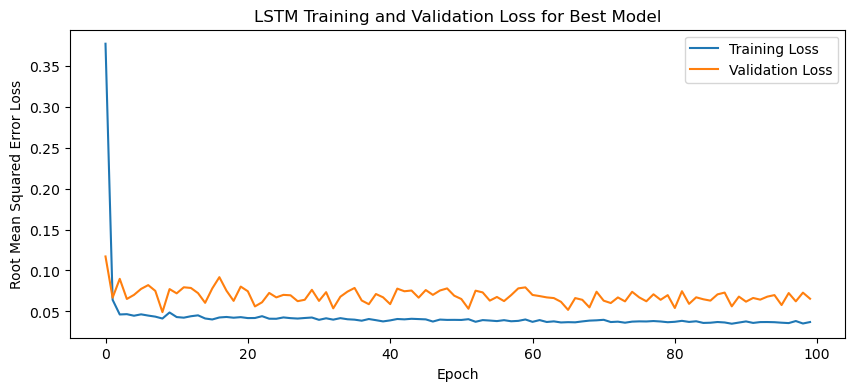

1/1 - 1s - loss: 0.0406 - 1s/epoch - 1s/step
Test Loss: 0.040565863251686096
1/1 [==============================] - 0s 79ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

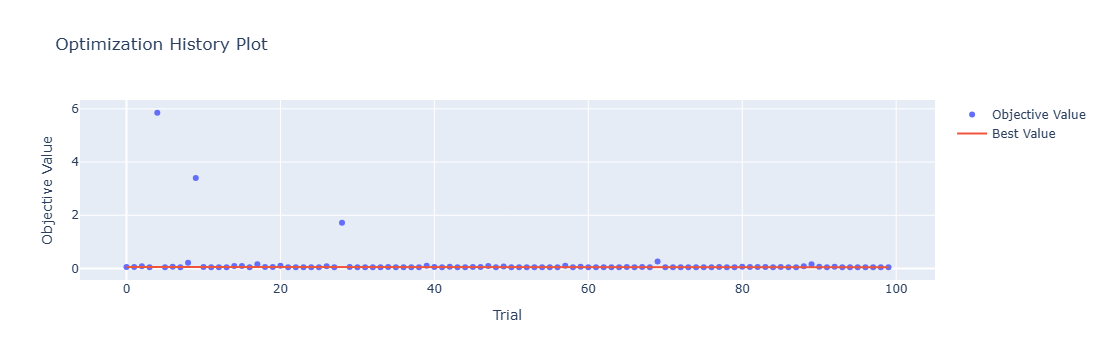

In [4]:
optuna.visualization.plot_optimization_history(study)

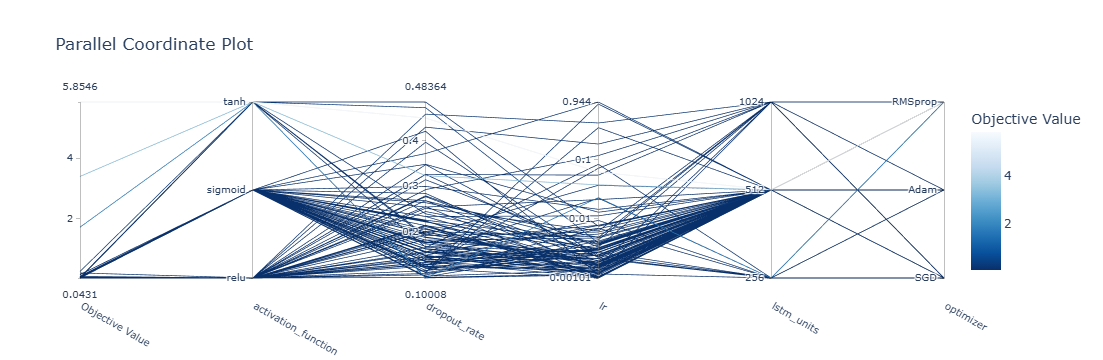

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

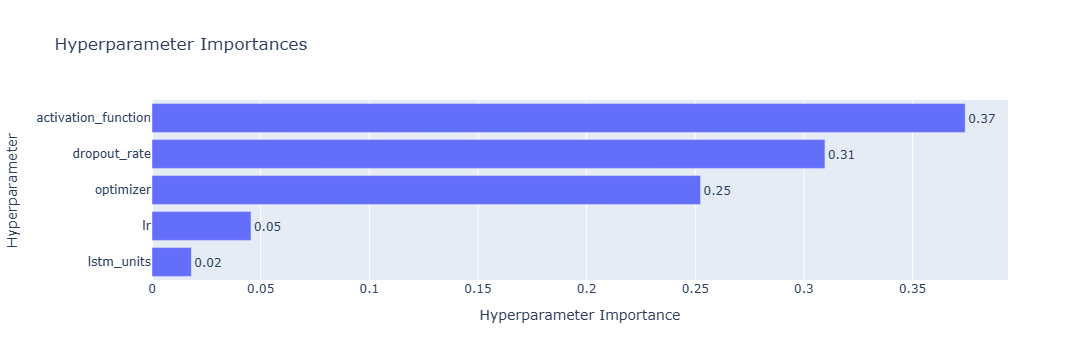

In [6]:
optuna.visualization.plot_param_importances(study)

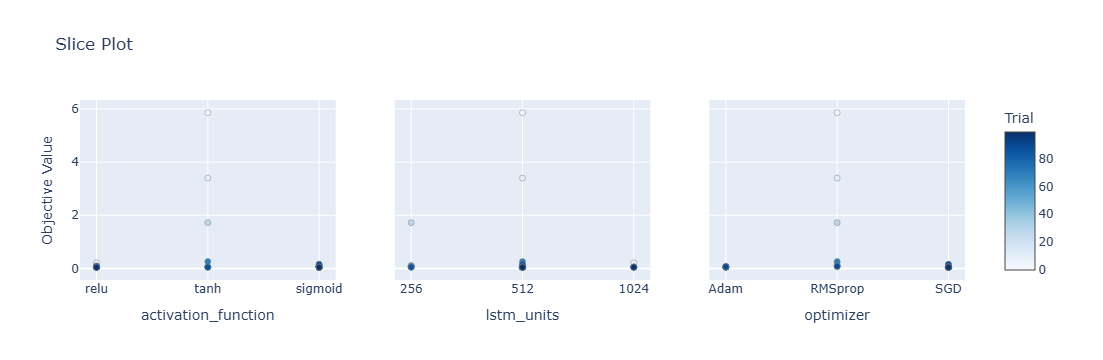

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

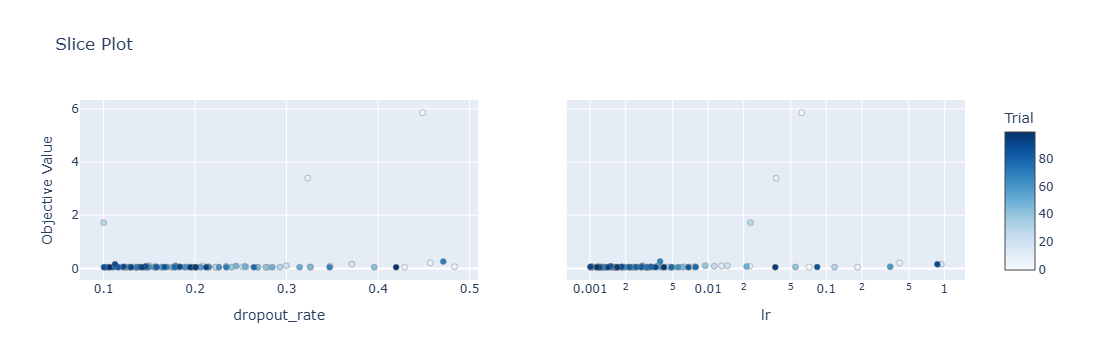

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

Epoch 1/100
84/84 [==============================] - 23s 81ms/step - loss: 0.2789 - accuracy: 0.8571 - mae: 0.2745 - rmse: 0.2789 - mape: 51.9968 - pearson: 0.7289 - val_loss: 0.0418 - val_accuracy: 0.9000 - val_mae: 0.0359 - val_rmse: 0.0418 - val_mape: 7.2225 - val_pearson: 0.6233
Epoch 2/100
84/84 [==============================] - 3s 33ms/step - loss: 0.0477 - accuracy: 0.8571 - mae: 0.0408 - rmse: 0.0477 - mape: 7.5824 - pearson: 0.7710 - val_loss: 0.0525 - val_accuracy: 0.9000 - val_mae: 0.0444 - val_rmse: 0.0525 - val_mape: 8.6790 - val_pearson: 0.7762
Epoch 3/100
84/84 [==============================] - 3s 31ms/step - loss: 0.0458 - accuracy: 0.8452 - mae: 0.0388 - rmse: 0.0458 - mape: 7.3135 - pearson: 0.8000 - val_loss: 0.0386 - val_accuracy: 0.9000 - val_mae: 0.0320 - val_rmse: 0.0386 - val_mape: 6.3064 - val_pearson: 0.8158
Epoch 4/100
84/84 [==============================] - 4s 43ms/step - loss: 0.0484 - accuracy: 0.8452 - mae: 0.0417 - rmse: 0.0484 - mape: 7.8603 - pearso

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



84/84 [==============================] - 4s 48ms/step - loss: 0.0409 - accuracy: 0.8690 - mae: 0.0343 - rmse: 0.0409 - mape: 6.4134 - pearson: 0.8094 - val_loss: 0.0390 - val_accuracy: 0.9000 - val_mae: 0.0347 - val_rmse: 0.0390 - val_mape: 6.6203 - val_pearson: 0.9098
Epoch 22/100
84/84 [==============================] - 4s 45ms/step - loss: 0.0413 - accuracy: 0.8690 - mae: 0.0350 - rmse: 0.0413 - mape: 6.5854 - pearson: 0.8044 - val_loss: 0.0384 - val_accuracy: 0.9000 - val_mae: 0.0338 - val_rmse: 0.0384 - val_mape: 6.3929 - val_pearson: 0.9141
Epoch 23/100
84/84 [==============================] - 4s 43ms/step - loss: 0.0419 - accuracy: 0.8690 - mae: 0.0355 - rmse: 0.0419 - mape: 6.6176 - pearson: 0.8099 - val_loss: 0.0388 - val_accuracy: 0.9000 - val_mae: 0.0336 - val_rmse: 0.0388 - val_mape: 6.3287 - val_pearson: 0.9141
Epoch 24/100
84/84 [==============================] - 4s 44ms/step - loss: 0.0415 - accuracy: 0.8690 - mae: 0.0349 - rmse: 0.0415 - mape: 6.4978 - pearson: 0.8060 -

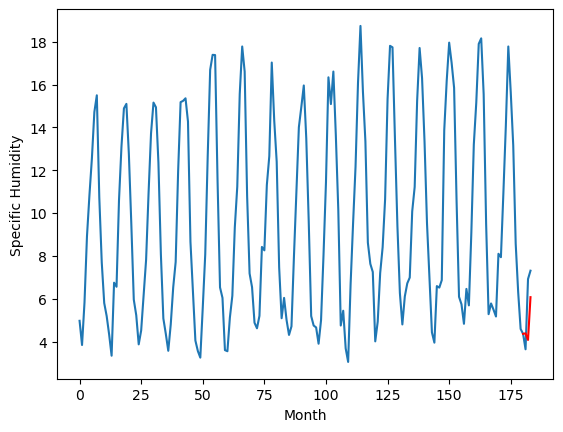

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.84		1.68		-0.16
1.16		1.35		0.19
3.01		3.24		0.23
[180, 181, 182, 183]
[2.82, 1.6834503853321074, 1.3452409052848815, 3.244594767093658]


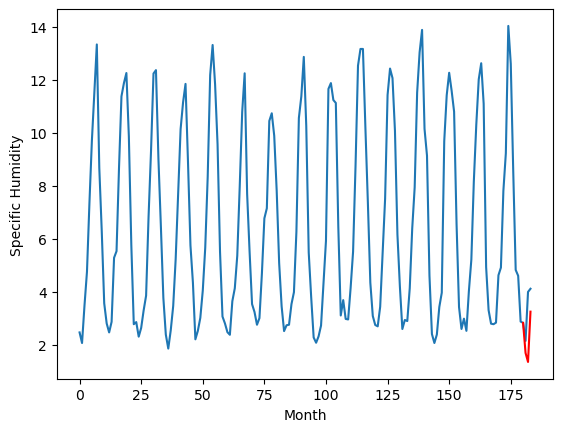

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.53		4.91		-0.62
7.66		4.73		-2.93
7.88		6.55		-1.33
[180, 181, 182, 183]
[9.16, 4.912195437550545, 4.7274789744615555, 6.549867027401924]


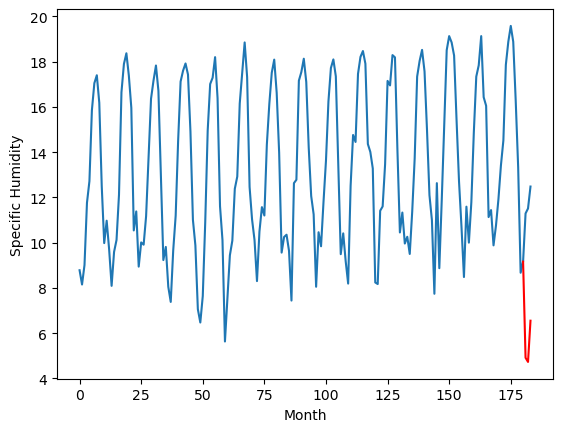

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.98		4.88		0.90
4.15		4.62		0.47
4.79		6.38		1.59
[180, 181, 182, 183]
[2.44, 4.880443466305732, 4.619137567877769, 6.3825614875555035]


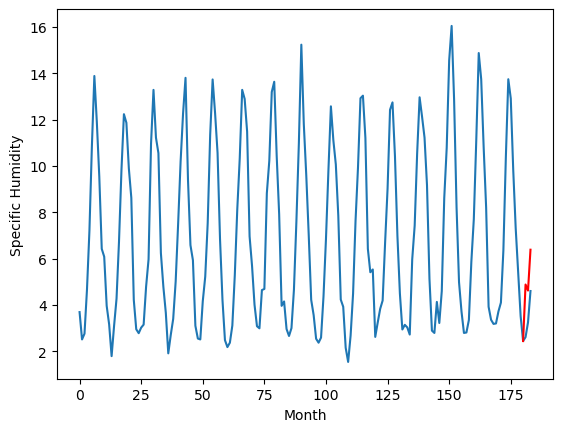

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.10		4.85		-0.25
5.08		4.72		-0.36
8.37		6.61		-1.76
[180, 181, 182, 183]
[6.65, 4.8547111389040944, 4.71578645080328, 6.609279268682003]


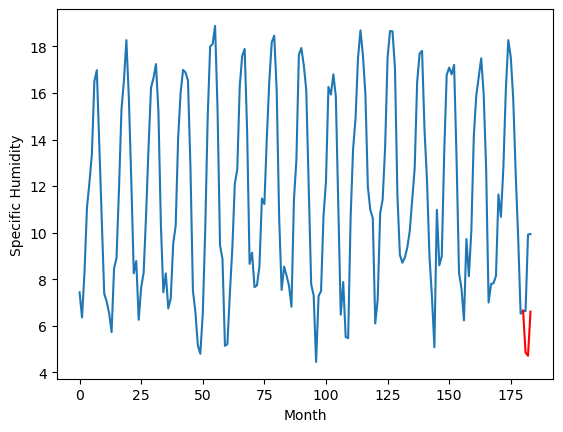

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.33		2.36		0.03
2.28		2.20		-0.08
5.27		4.13		-1.14
[180, 181, 182, 183]
[6.19, 2.3615927091240883, 2.2007496199011802, 4.131317838132381]


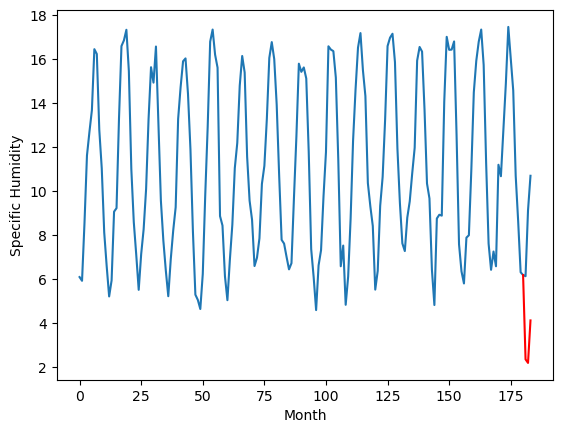

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.68		8.67		-0.01
8.35		8.48		0.13
11.21		10.45		-0.76
[180, 181, 182, 183]
[4.78, 8.673366239964961, 8.483699626028537, 10.447488731443881]


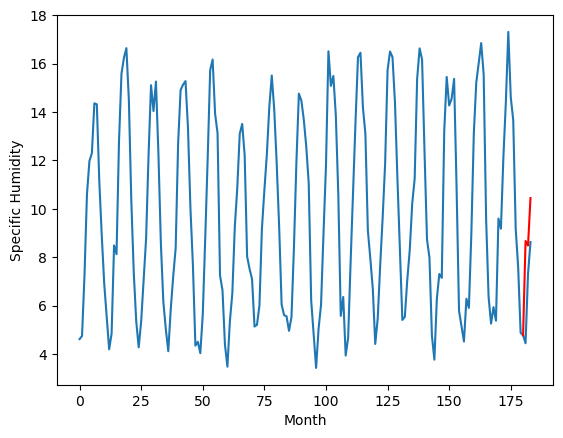

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.97		3.60		-0.37
3.84		3.41		-0.43
3.93		5.22		1.29
[180, 181, 182, 183]
[2.61, 3.5974154570698738, 3.4135543504357337, 5.217353383600711]


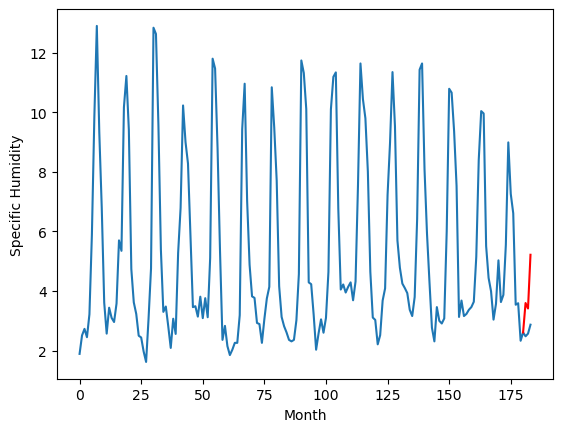

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.29		7.37		-0.92
8.82		7.18		-1.64
8.93		8.79		-0.14
[180, 181, 182, 183]
[4.6, 7.371010089814663, 7.17837798088789, 8.79305791348219]


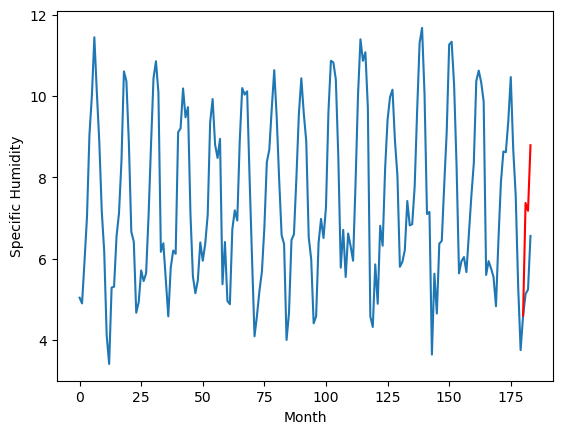

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.98		5.99		0.01
6.05		5.83		-0.22
7.78		7.61		-0.17
[180, 181, 182, 183]
[4.27, 5.994917473196983, 5.833946993947029, 7.614141872525215]


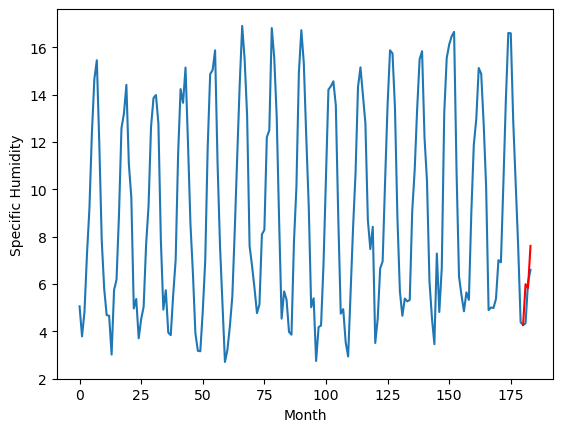

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.63		4.49		-0.14
4.87		4.33		-0.54
5.90		6.17		0.27
[180, 181, 182, 183]
[3.91, 4.493624056577683, 4.330894972085953, 6.166479254961014]


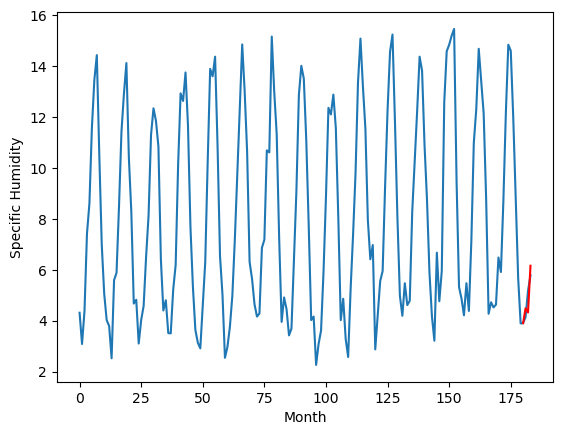

RangeIndex(start=1, stop=12, step=1)
[4.390000000000001, 1.8399999999999992, 5.529999999999999, 3.9799999999999995, 5.1, 2.33, 8.68, 3.9700000000000006, 8.29, 5.9799999999999995, 4.63]
[4.384486059546471, 1.6834503853321074, 4.912195437550545, 4.880443466305732, 4.8547111389040944, 2.3615927091240883, 8.673366239964961, 3.5974154570698738, 7.371010089814663, 5.994917473196983, 4.493624056577683]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.39   4.384486
1                 1    1.84   1.683450
2                 2    5.53   4.912195
3                 3    3.98   4.880443
4                 4    5.10   4.854711
5                 5    2.33   2.361593
6                 6    8.68   8.673366
7                 7    3.97   3.597415
8                 8    8.29   7.371010
9                 9    5.98   5.994917
10               10    4.63   4.493624


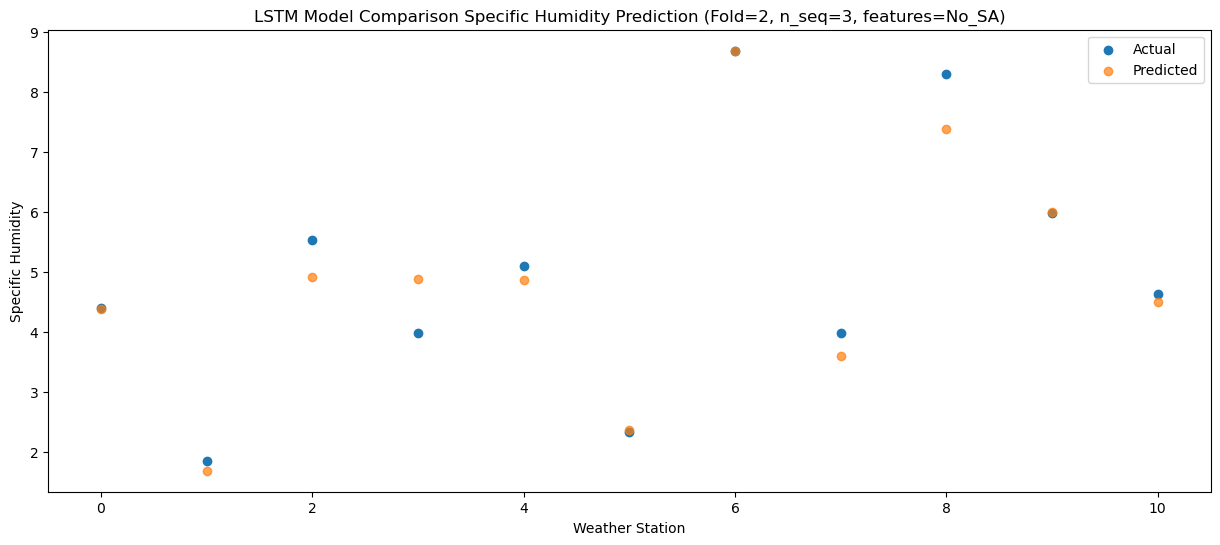

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    3.67   4.075550
1                 1    1.16   1.345241
2                 2    7.66   4.727479
3                 3    4.15   4.619138
4                 4    5.08   4.715786
5                 5    2.28   2.200750
6                 6    8.35   8.483700
7                 7    3.84   3.413554
8                 8    8.82   7.178378
9                 9    6.05   5.833947
10               10    4.87   4.330895


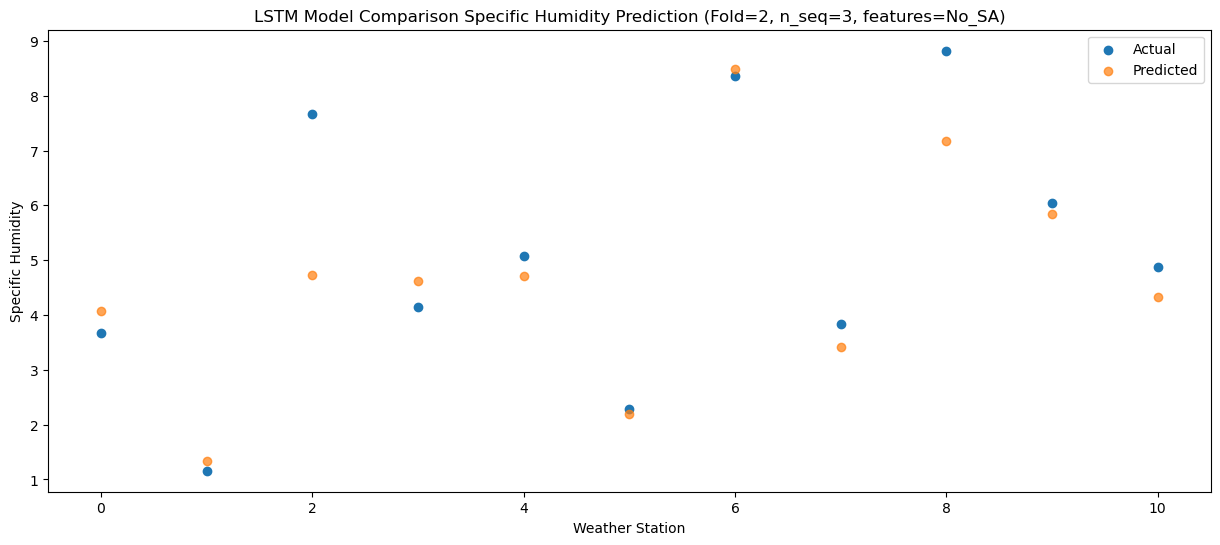

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    6.95   6.073790
1                 1    3.01   3.244595
2                 2    7.88   6.549867
3                 3    4.79   6.382561
4                 4    8.37   6.609279
5                 5    5.27   4.131318
6                 6   11.21  10.447489
7                 7    3.93   5.217353
8                 8    8.93   8.793058
9                 9    7.78   7.614142
10               10    5.90   6.166479


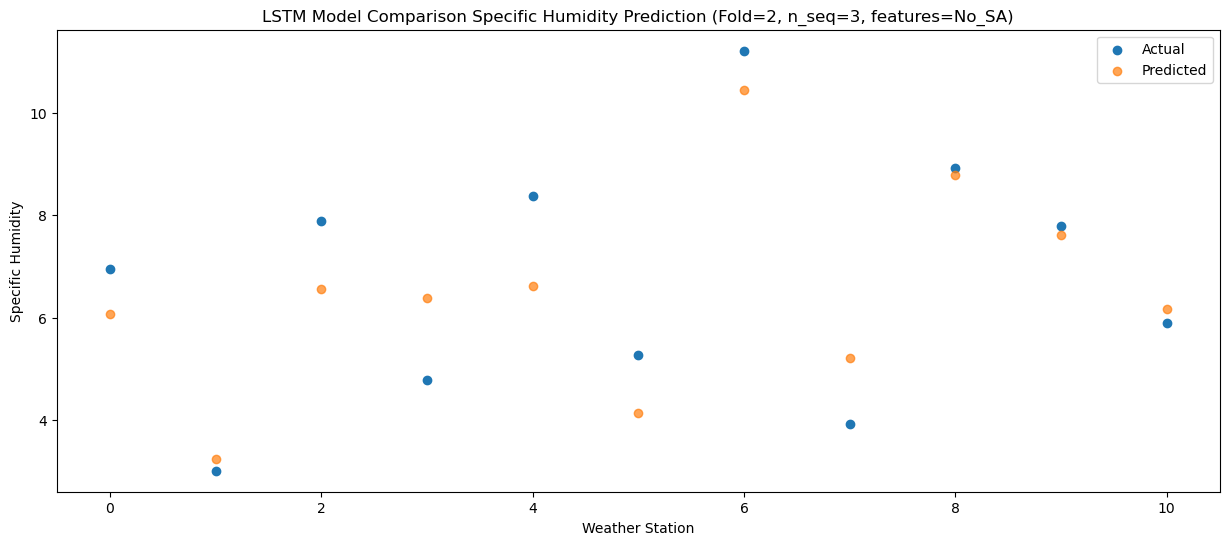

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_4 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_5 (LSTM)               (1, 512)                  2099200   
                                                                 
 dropout_5 (Dropout)         (1, 512)                  0         
                                                                 
 dense_6 (Dense)             (1, 256)                  131328    
                                                                 
 dense_7 (Dense)             (1, 128)                  32896     
                                                                 
 dense_8 (Dense)             (1, 3)                   

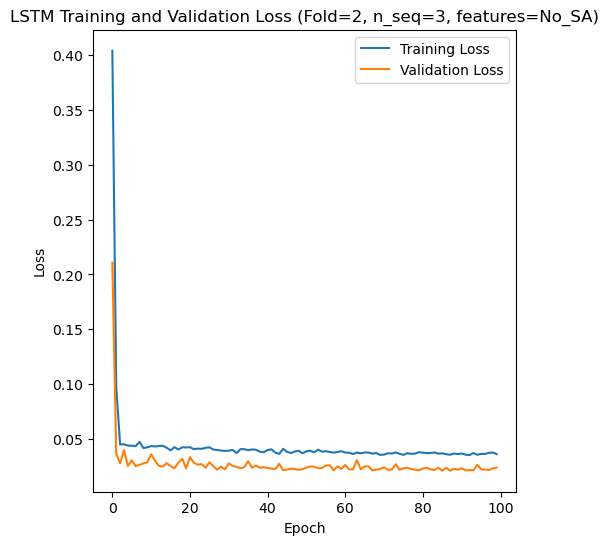

Epoch 1/100
84/84 [==============================] - 27s 138ms/step - loss: 0.2637 - accuracy: 0.8095 - mae: 0.2580 - rmse: 0.2637 - mape: 48.6262 - pearson: 0.6478 - val_loss: 0.0333 - val_accuracy: 0.8000 - val_mae: 0.0300 - val_rmse: 0.0333 - val_mape: 5.7587 - val_pearson: 0.8495
Epoch 2/100
84/84 [==============================] - 7s 81ms/step - loss: 0.0476 - accuracy: 0.9048 - mae: 0.0406 - rmse: 0.0476 - mape: 7.5884 - pearson: 0.8364 - val_loss: 0.0462 - val_accuracy: 0.8000 - val_mae: 0.0404 - val_rmse: 0.0462 - val_mape: 8.0222 - val_pearson: 0.8542
Epoch 3/100
84/84 [==============================] - 7s 84ms/step - loss: 0.0444 - accuracy: 0.8929 - mae: 0.0380 - rmse: 0.0444 - mape: 7.0544 - pearson: 0.8438 - val_loss: 0.0301 - val_accuracy: 0.8000 - val_mae: 0.0273 - val_rmse: 0.0301 - val_mape: 5.3351 - val_pearson: 0.8539
Epoch 4/100
84/84 [==============================] - 7s 81ms/step - loss: 0.0477 - accuracy: 0.9048 - mae: 0.0417 - rmse: 0.0477 - mape: 7.7872 - pears

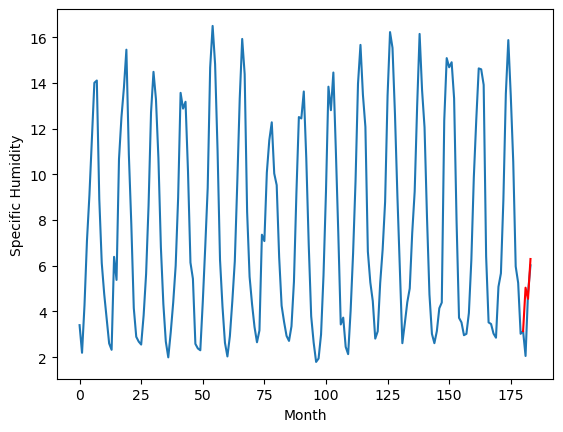

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.27		3.83		-0.44
6.26		3.53		-2.73
6.23		5.23		-1.00
[180, 181, 182, 183]
[7.79, 3.8275460210442542, 3.5295738485455512, 5.230810573399067]


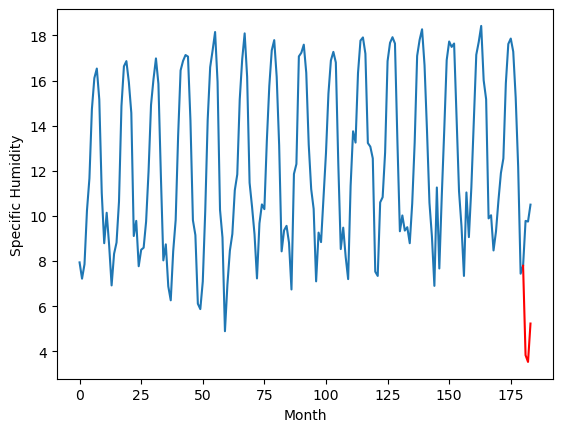

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.87		3.91		0.04
3.75		3.66		-0.09
6.81		5.43		-1.38
[180, 181, 182, 183]
[5.03, 3.910182382464409, 3.6567737716436386, 5.426757778525353]


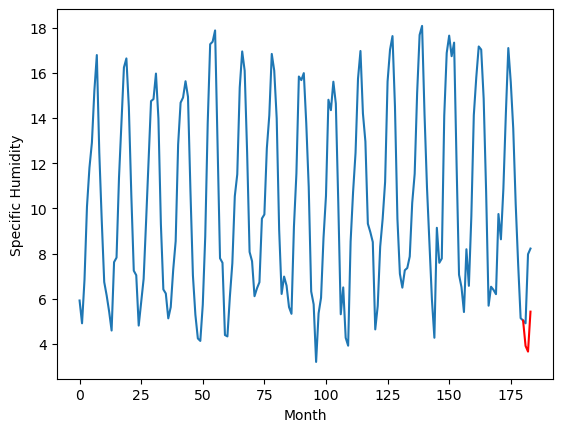

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.73		3.77		0.04
3.41		3.49		0.08
6.07		5.32		-0.75
[180, 181, 182, 183]
[4.41, 3.7706493401527403, 3.4891638123989104, 5.323460396528244]


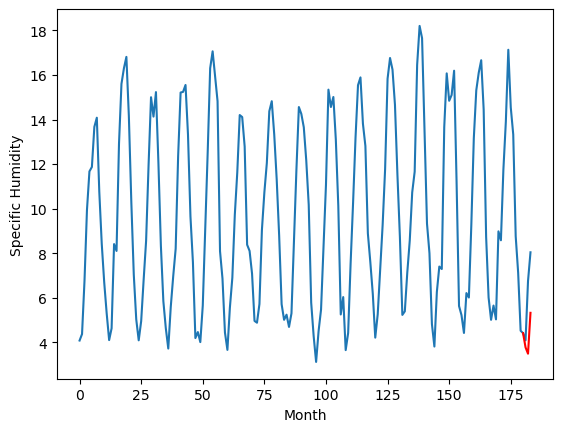

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.36		3.35		-0.01
2.91		3.06		0.15
5.49		4.94		-0.55
[180, 181, 182, 183]
[4.29, 3.348234714567661, 3.0598603203892707, 4.943563671410084]


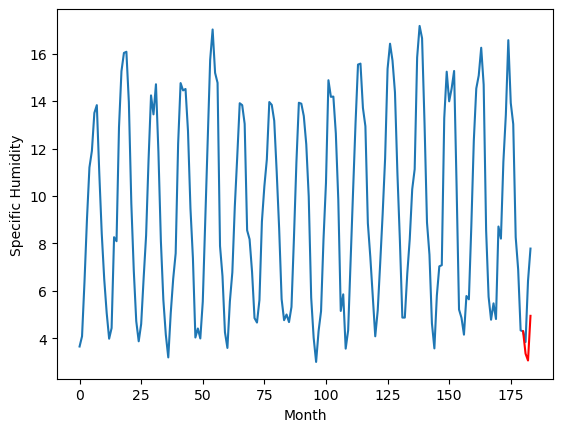

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.64		7.89		-0.75
8.00		7.58		-0.42
9.49		9.36		-0.13
[180, 181, 182, 183]
[3.47, 7.891346322894097, 7.583606707453728, 9.3611093634367]


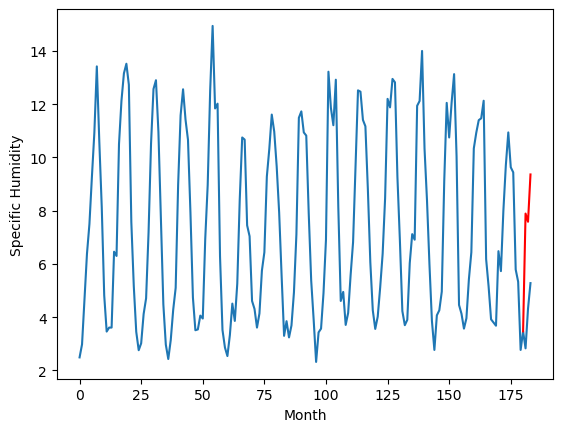

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.80		5.85		0.05
6.05		5.62		-0.43
7.76		7.39		-0.37
[180, 181, 182, 183]
[4.52, 5.845180219113827, 5.620449906289577, 7.386140352189541]


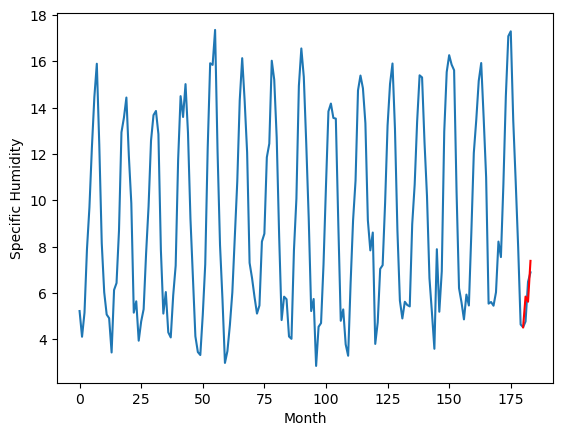

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.93		3.96		0.03
3.30		3.67		0.37
5.67		5.52		-0.15
[180, 181, 182, 183]
[3.4, 3.9648299011588097, 3.6738244089484215, 5.520845869481564]


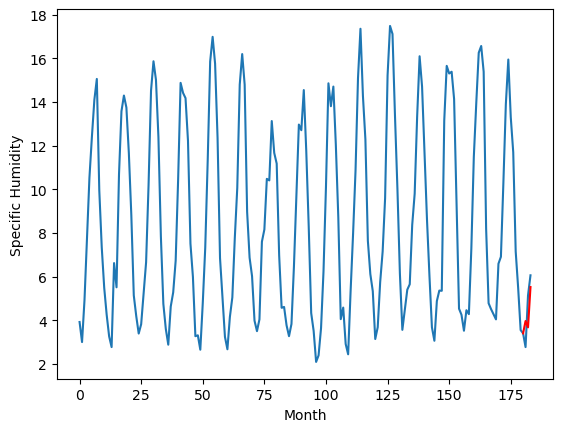

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.30		3.45		0.15
2.73		3.11		0.38
4.67		4.89		0.22
[180, 181, 182, 183]
[2.82, 3.448373982310295, 3.1087212055921554, 4.89375419318676]


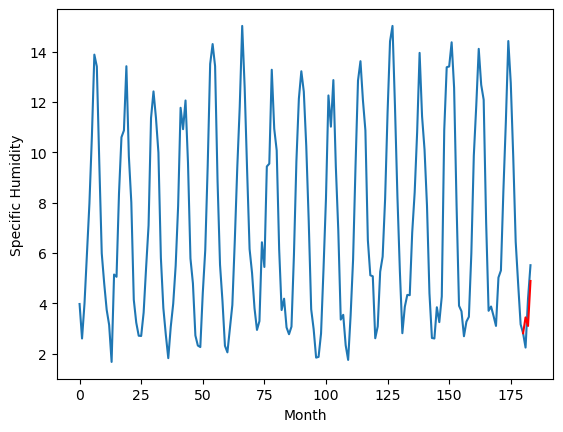

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.17		2.26		0.09
1.53		1.87		0.34
3.90		3.70		-0.20
[180, 181, 182, 183]
[2.86, 2.2621711397171023, 1.8669106864929201, 3.7036272192001345]


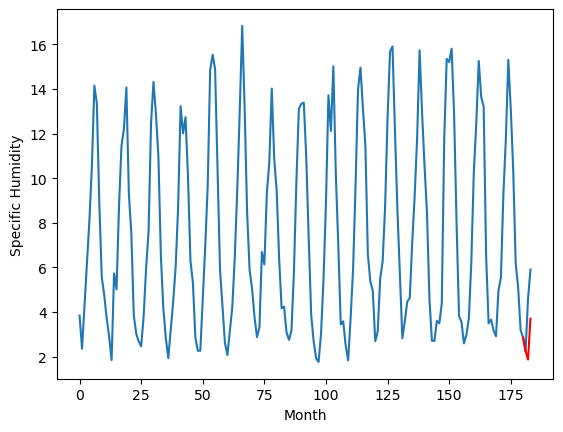

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		4.91		0.07
4.27		4.49		0.22
5.56		6.21		0.65
[180, 181, 182, 183]
[2.61, 4.913871527910232, 4.494538546800613, 6.214312435388565]


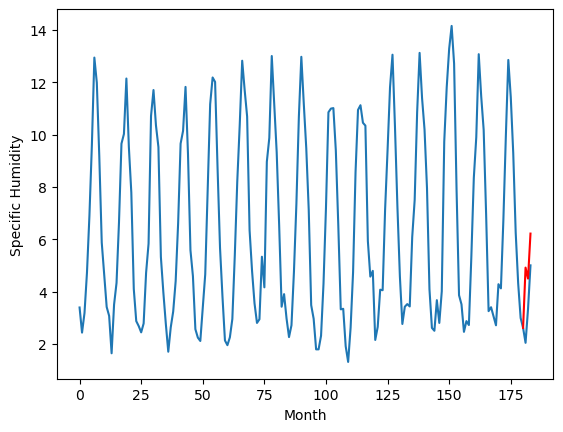

RangeIndex(start=1, stop=12, step=1)
[5.34, 4.269999999999999, 3.870000000000001, 3.7300000000000004, 3.3600000000000003, 8.64, 5.8, 3.93, 3.3000000000000003, 2.1699999999999995, 4.839999999999999]
[5.039525837898254, 3.8275460210442542, 3.910182382464409, 3.7706493401527403, 3.348234714567661, 7.891346322894097, 5.845180219113827, 3.9648299011588097, 3.448373982310295, 2.2621711397171023, 4.913871527910232]
Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    5.34   5.039526
1                 1    4.27   3.827546
2                 2    3.87   3.910182
3                 3    3.73   3.770649
4                 4    3.36   3.348235
5                 5    8.64   7.891346
6                 6    5.80   5.845180
7                 7    3.93   3.964830
8                 8    3.30   3.448374
9                 9    2.17   2.262171
10               10    4.84   4.913872


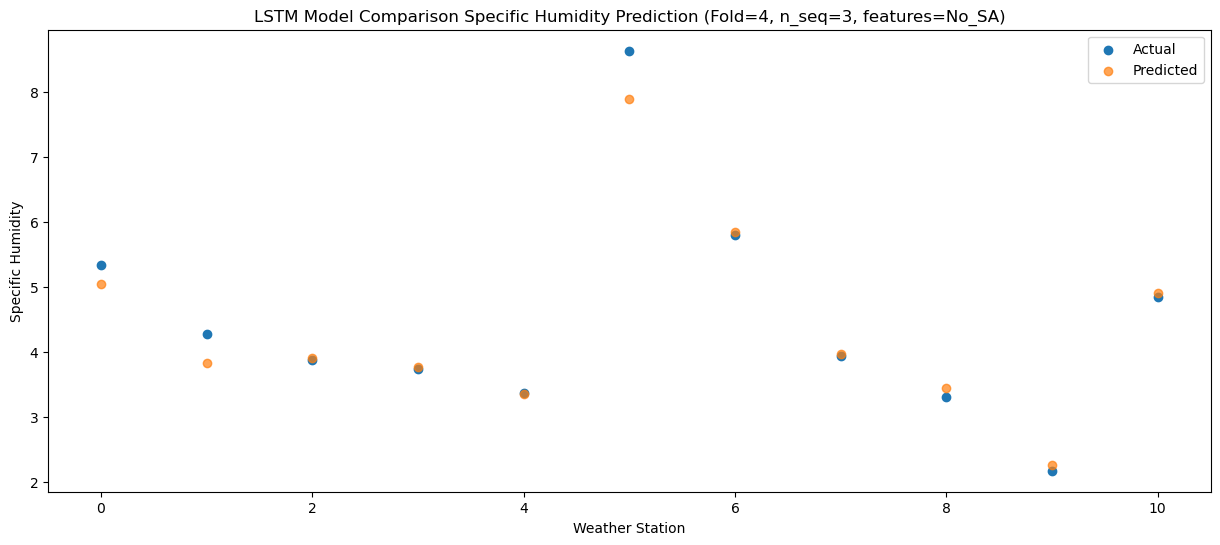

Predictions for (t+1):
    Weather_Station  Actual  Predicted
0                 0    4.25   4.553252
1                 1    6.26   3.529574
2                 2    3.75   3.656774
3                 3    3.41   3.489164
4                 4    2.91   3.059860
5                 5    8.00   7.583607
6                 6    6.05   5.620450
7                 7    3.30   3.673824
8                 8    2.73   3.108721
9                 9    1.53   1.866911
10               10    4.27   4.494539


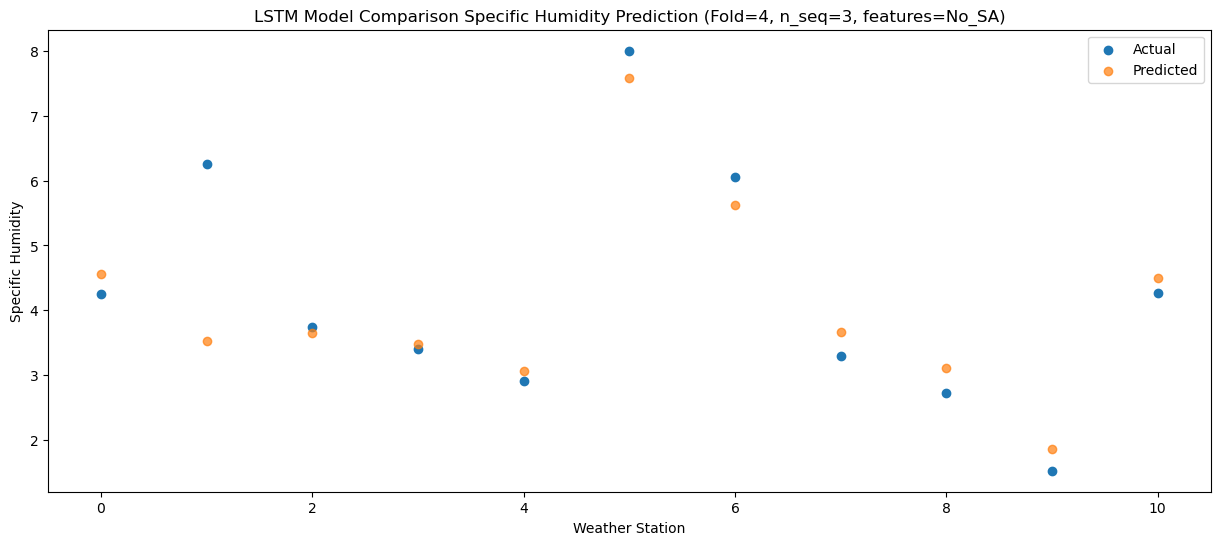

Predictions for (t+2):
    Weather_Station  Actual  Predicted
0                 0    7.01   6.295567
1                 1    6.23   5.230811
2                 2    6.81   5.426758
3                 3    6.07   5.323460
4                 4    5.49   4.943564
5                 5    9.49   9.361109
6                 6    7.76   7.386140
7                 7    5.67   5.520846
8                 8    4.67   4.893754
9                 9    3.90   3.703627
10               10    5.56   6.214312


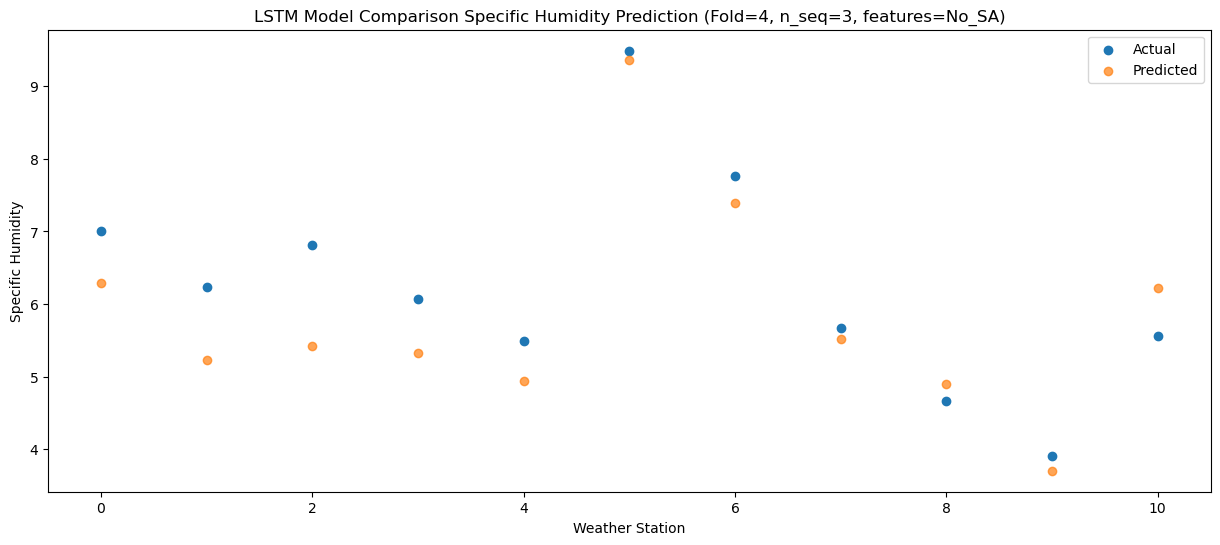

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 512)               5083136   
                                                                 
 dropout_8 (Dropout)         (1, 1, 512)               0         
                                                                 
 lstm_9 (LSTM)               (1, 512)                  2099200   
                                                                 
 dropout_9 (Dropout)         (1, 512)                  0         
                                                                 
 dense_12 (Dense)            (1, 256)                  131328    
                                                                 
 dense_13 (Dense)            (1, 128)                  32896     
                                                                 
 dense_14 (Dense)            (1, 3)                   

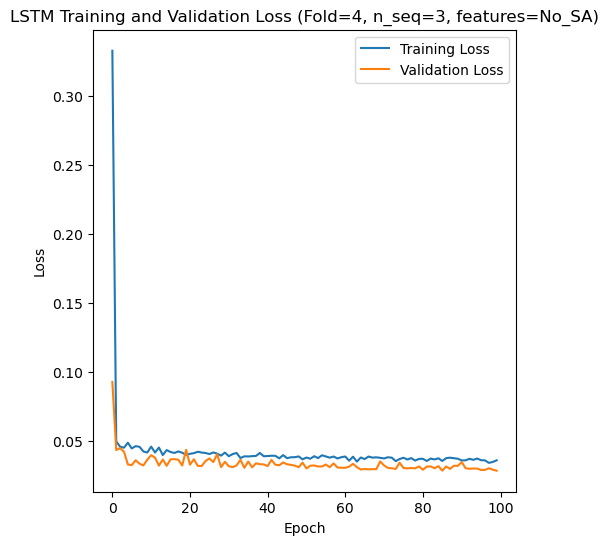

[[0.30443911991249634, 0.572772108594416, 0.8726964850522153], [0.3664922751352144, 0.44399150544557875, 0.6569010525369965], [0.45531312460483286, 1.0612794362754285, 1.039273957606609], [0.5540266706918073, 0.6354076330312047, 0.5635511637252745], [0.28431092502246785, 0.8733218907394815, 0.6724075772947173]]
[[0.2687608421921981, 0.44481375656916117, 0.7059491141739467], [0.29482570932791813, 0.35323106199624665, 0.5761341191409689], [0.3096995258060367, 0.672076277705756, 0.86836781358177], [0.4040263117985292, 0.5008506246588444, 0.47559713000600967], [0.17987323603846803, 0.5014424326744946, 0.5560168013247577]]
[[0.049314093779142414, 0.09221117189002116, 0.09798762409792729], [0.07190796921452053, 0.07803169763659168, 0.09290920604480327], [0.0657610918868978, 0.12110280178705862, 0.14628430464102857], [0.1121287880402836, 0.131007127748016, 0.11043294605590376], [0.03551563924465995, 0.11408553275840858, 0.09017755572332921]]
[[0.9155084523781558, 0.8093381602383313, 0.3012978

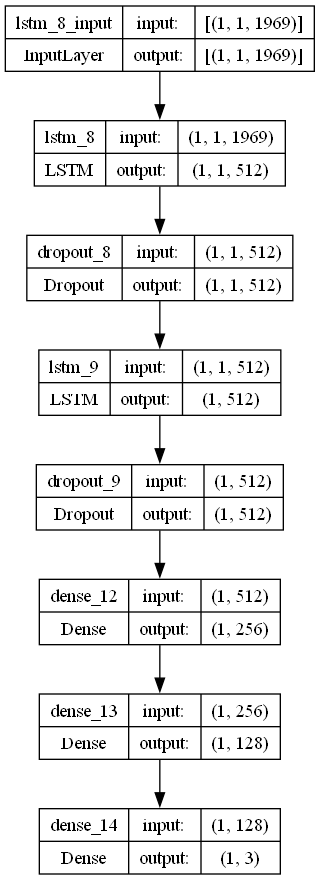

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# fit best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from best model
    lr = 0.0029533499173309903
    optimizer = SGD(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 512
    dropout_rate = 0.13416040811538799

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with an LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # Create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse_avg_list = []
mae_avg_list = []
mape_avg_list = []
r2_score_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction

    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse_avg_list.append(rmse_list)
    mae_avg_list.append(mae_list)
    mape_avg_list.append(mape_list)
    r2_score_avg_list.append(r2_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)

    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        
        plot_forecasts(series_ws, forecasts_ws, n_test, n_seq, n_lag)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)
            
        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse_avg_list)
print(mae_avg_list)
print(mape_avg_list)
print(r2_score_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse_avg_list)
print("Average RMSE:"+str(np.mean(rmse_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S3_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)